# Notebook to make the graphs

## Reading the CSV files with the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Direct / No self-correction"

metrics_direct_no_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-18T22-05-45.csv")

# Step-by-step / No self-correction

metrics_step_no_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-16T12-26-17.csv")
    
# Direct / Self-correction

metrics_direct_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-19T17-10-43.csv")

# Step-by-step / Self-correction

metrics_step_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-21T22-28-09.csv")

In [ ]:
# Adding gold_difficulty column for the graphs

df_test = pd.read_csv("datasets/txt2sql_alerce_test_v3_1.csv")
metrics_step_corr["gold_difficulty"] = ""
metrics_direct_corr["gold_difficulty"] = ""
metrics_step_no_corr["gold_difficulty"] = ""
metrics_direct_no_corr["gold_difficulty"] = ""

for req_id in df_test["req_id"].unique():
    mask = (metrics_step_corr["query_id"] == req_id) & (metrics_step_corr["query_run"] != 0)
    metrics_step_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_corr["query_id"] == req_id) & (metrics_direct_corr["query_run"] != 0)
    metrics_direct_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_step_no_corr["query_id"] == req_id) & (metrics_step_no_corr["query_run"] != 0)
    metrics_step_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_no_corr["query_id"] == req_id) & (metrics_direct_no_corr["query_run"] != 0)
    metrics_direct_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    #print(df_test.loc[df_test.req_id == req_id, "difficulty"].item())

In [46]:
metrics_step_corr["gold_difficulty"].value_counts()

gold_difficulty
simple      320
advanced    100
medium      100
             52
Name: count, dtype: int64

## Making the graphs

### No self-correction

simple Direct


N_perfect_row
0.000000    30
0.516398     1
0.316228     1
Name: count, dtype: int64

simple Step-by-Step


N_perfect_row
0.000000    29
0.421637     1
0.516398     1
0.316228     1
Name: count, dtype: int64

medium Direct


N_perfect_row
0.000000    8
0.483046    1
0.316228    1
Name: count, dtype: int64

medium Step-by-Step


N_perfect_row
0.000000    8
0.516398    1
0.316228    1
Name: count, dtype: int64

advanced Direct


N_perfect_row
0.000000    7
0.421637    2
0.316228    1
Name: count, dtype: int64

advanced Step-by-Step


N_perfect_row
0.000000    7
0.421637    1
0.483046    1
0.316228    1
Name: count, dtype: int64

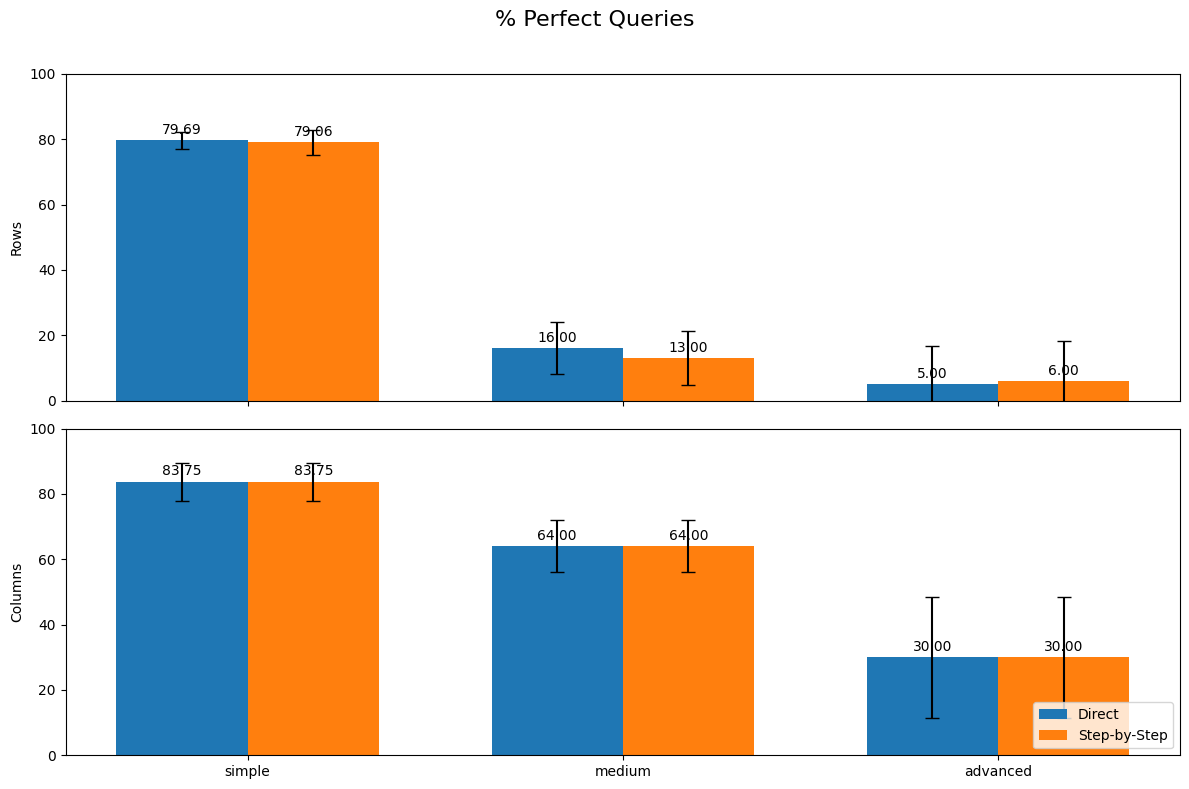

In [ ]:
# Add prompt type before combining
metrics_direct_no_corr['prompt_type'] = 'Direct'
metrics_step_no_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_no_corr = metrics_direct_no_corr[metrics_direct_no_corr["query_run"] != 0]
metrics_step_no_corr = metrics_step_no_corr[metrics_step_no_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_no_corr, metrics_step_no_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:  # cambiar nombre label a difficulty
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=16)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows")
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns")
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order)

# Legend
axs[1].legend(loc="lower right")

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


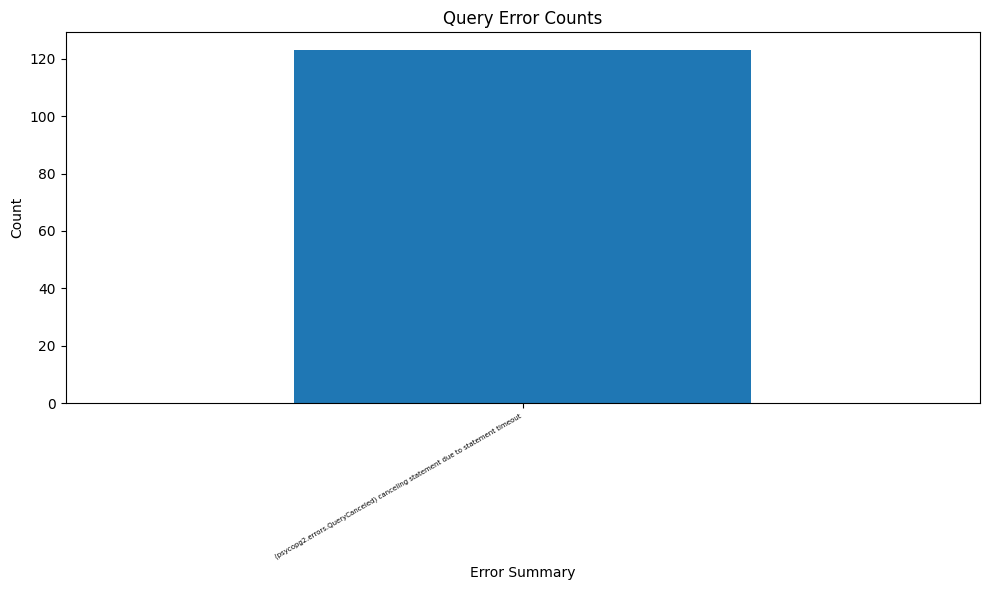

In [48]:
# Apply the transformation
processed = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all["query_error"]
]

counts = pd.Series(processed).value_counts(dropna=True)
counts = counts[counts > 10]
# counts.index = counts.index.fillna('NaN')

# Plot with better spacing
plt.figure(figsize=(10, 6))  # Make the plot wider
ax = counts.plot(kind='bar')

plt.title('Query Error Counts')
plt.xlabel('Error Summary')
plt.ylabel('Count')

# Improve spacing of x-axis labels
plt.xticks(
    ticks=range(len(counts)),
    labels=counts.index,
    rotation=30,     # Rotate slightly
    ha='right',      # Align right
    fontsize=5      # Optional: reduce font size
)

plt.tight_layout()
plt.show()

### With self-correction

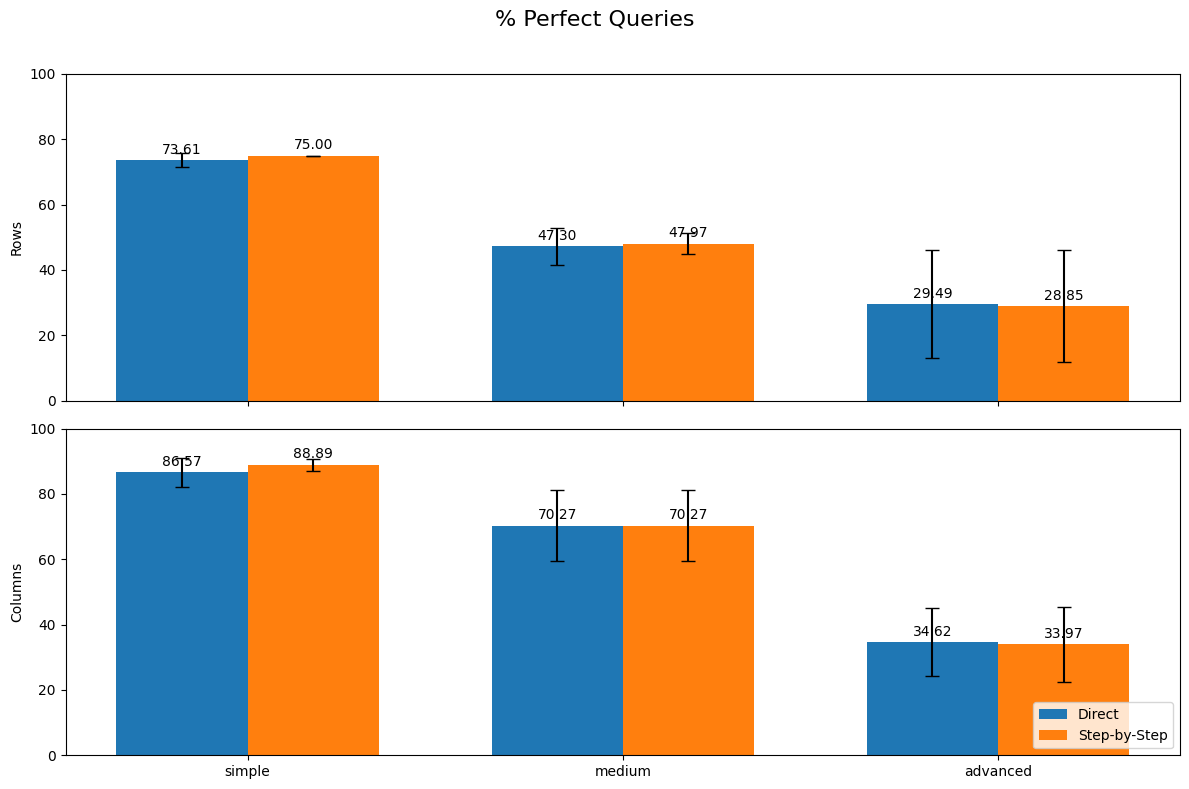

In [ ]:
# Add prompt type before combining
metrics_direct_corr['prompt_type'] = 'Direct'
metrics_step_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_corr = metrics_direct_corr[metrics_direct_corr["query_run"] != 0]
metrics_step_corr = metrics_step_corr[metrics_step_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_corr, metrics_step_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=16)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows")
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns")
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order)

# Legend
axs[1].legend(loc="lower right")

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

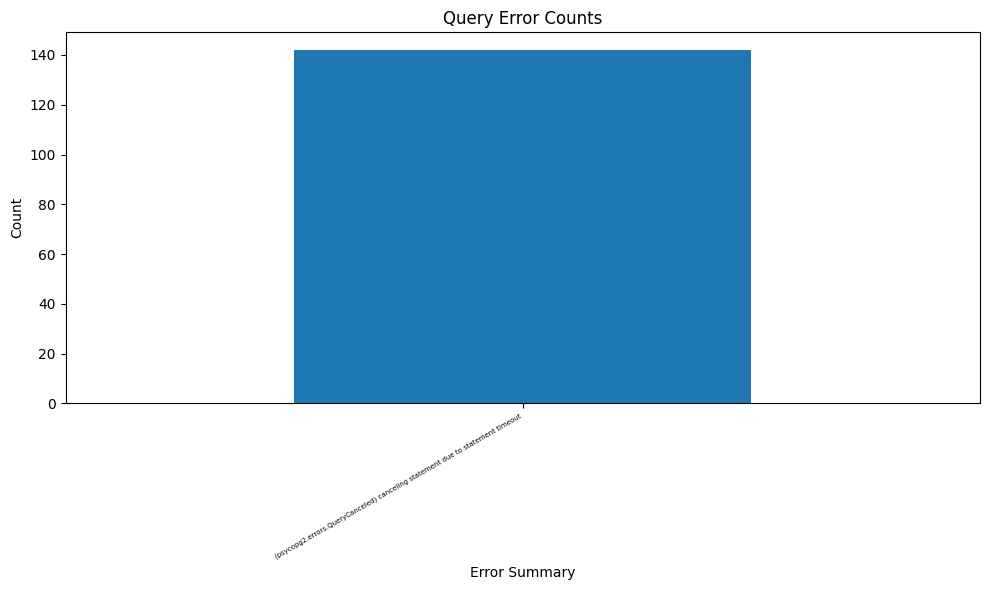

In [36]:
# Apply the transformation
processed = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all["query_error"]
]

counts = pd.Series(processed).value_counts(dropna=True)
counts = counts[counts > 10]
# counts.index = counts.index.fillna('NaN')

# Plot with better spacing
plt.figure(figsize=(10, 6))  # Make the plot wider
ax = counts.plot(kind='bar')

plt.title('Query Error Counts')
plt.xlabel('Error Summary')
plt.ylabel('Count')

# Improve spacing of x-axis labels
plt.xticks(
    ticks=range(len(counts)),
    labels=counts.index,
    rotation=30,     # Rotate slightly
    ha='right',      # Align right
    fontsize=5      # Optional: reduce font size
)

plt.tight_layout()
plt.show()